In [61]:
%run runaway_functionsv3

In [66]:
ra = cl.runaways_all()

In [69]:
ra['Temp. Est'] = ra["Teff"]

In [70]:
Ttheo = thiso['Teff0']
bprptheo = thiso['BP-RP']
gmagtheo = thiso['Gmag']
for star in ra:
    differences_bprp = abs(bprptheo - star['BP-RP'])
    differences_gmag = abs(gmagtheo - star['Gmag'])
    # differences = differences_bprp**2+differences_gmag**2 #method 1
    differences = differences_bprp #method 2
    closest_star_index = np.argmin(differences)
    new_closest_star_temperature = Ttheo[closest_star_index]
    star['Temp. Est']=new_closest_star_temperature

In [71]:
ra

RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,v_pec,Temp. Est
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,km / s,K
float64,float64,float64,float64,float64,int32,str11,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64
132.98671546278,-41.67380294722,0.0076,0.0094,16.3689,--,7684-947-1,5524617227420570240,828.71801800,1.1916,0.0106,8.476,3.166,0.010,0.012,0.945,--,--,9.615953,1.578032,10.358509,8.780477,5.27,0.13,821.67810100,834.74066200,2682658.85519,486.4,9.818e+05,495.1,2.438e+06,523.2,--,--,0.002762,0.002843,0.003787,0.00663,"132.98671546278,-41.67380294722,828.718018",14.006720710754395,-0.75391925239563,55.099771647367824,4873.0
132.26918571419,-41.86012579175,0.0194,0.0219,17.6322,--,--,5524602036116091520,814.32153300,1.1904,0.0254,-10.707,7.029,0.026,0.029,1.723,8231.5,4.0056,11.258210,0.356719,11.384149,11.027430,31.10,2.85,796.94012500,831.44531200,591102.51261,175.7,3.817e+05,229,3.077e+05,96.41,--,--,0.002774,0.002865,0.003795,0.00666,"132.26918571419,-41.86012579175,814.321533",-5.176279289245606,3.10908074760437,23.30687698503049,10310.0
133.04493592329,-41.59435475046,0.0241,0.0283,20.7259,--,7684-653-1,5524617914615284992,979.94305400,1.0132,0.0324,-0.307,7.280,0.029,0.034,2.451,--,--,11.336214,1.615958,12.098172,10.482214,26.91,0.22,947.73254400,1010.28107000,550124.88210,174.1,1.978e+05,106.3,5.085e+05,146.3,--,--,0.002777,0.002851,0.003792,0.006643,"133.04493592329,-41.59435475046,979.943054",5.223720710754394,3.3600807476043704,28.849989642023935,4807.0
132.73410499438,-41.84178400134,0.0099,0.0105,6.2903,--,--,5524590426825145856,1018.10675000,0.9673,0.0125,0.455,-1.558,0.014,0.014,1.012,--,--,11.569294,1.596606,12.318983,10.722377,17.29,0.22,1003.93256000,1031.12170000,443842.79468,134.2,1.614e+05,129.4,4.076e+05,174.6,--,--,0.002775,0.002923,0.003808,0.006731,"132.73410499438,-41.84178400134,1018.10675",5.985720710754395,-5.47791925239563,39.156590279772615,4843.0
132.59406399603,-42.09002153710,0.0079,0.0094,19.7340,--,--,5524580526922315776,967.59924300,1.0075,0.0104,-1.221,-0.708,0.011,0.012,0.895,--,--,11.824070,0.888767,12.178180,11.289412,6.41,4.58,955.04718000,978.97412100,351009.54390,43.63,1.837e+05,94.49,2.418e+05,69.53,--,--,0.002759,0.002845,0.003792,0.006638,"132.59406399603,-42.0900215371,967.599243",4.3097207107543944,-4.62791925239563,29.003925519374672,6927.0
133.00847043200,-41.59308957469,0.0081,0.0098,19.3563,--,7684-575-1,5524618155133464576,811.05267300,1.2004,0.0111,-0.255,2.102,0.010,0.012,0.964,--,--,12.213220,0.457366,12.382430,11.925064,11.78,3.30,803.58398400,818.88946500,245278.17556,38.01,1.522e+05,64.06,1.346e+05,37.87,--,--,0.00276,0.002827,0.003792,0.006619,"133.008470432,-41.59308957469,811.052673",5.275720710754395,-1.81791925239563,21.452265989142795,9078.0
132.87533316669,-41.69470930427,0.0068,0.0081,11.2519,--,--,5524616261047795200,852.32055700,1.1546,0.0090,-11.087,2.875,0.009,0.010,0.864,5947.3,3.7638,12.487675,0.887664,12.844776,11.957112,46.70,1.21,845.25250200,859.78521700,190492.02971,28.59,9.943e+04,69.04,1.307e+05,47.97,--,--,0.00276,0.00289,0.0038,0.006691,"132.87533316669,-41.69470930427,852.320557",-5.556279289245605,-1.0449192523956299,22.84086340674451,7085.0
132.61000098041,-41.54121706697,0.0077,0.0088,13.3811,--,--,5524610458552201472,894.27368200,1.0954,0.0101,-15.826,12.544,0.010,0.011,1.000,--,--,12.577625,0.760202,12.872737,12.112535,--,--,885.06213400,901.41918900,175346.30748,23.81,9.69e+04,53.97,1.1

In [60]:
cl = Cluster("Alessi_43")
cl.theoretical_isochrone()

Mass,Teff0,BP-RP,Gmag,G_BP,G_RP,logg,logAge,logL,logTe,Mini
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.09,2552.0,4.450999999999999,22.058708663695164,15.04,10.589,3.833,6.763,-1.861,3.4069,0.0900000036
0.092,2557.0,4.4510000000000005,22.037708663695163,15.018,10.567,3.836,6.763,-1.853,3.4078,0.0915648341
0.094,2564.0,4.452,22.01170866369516,14.993,10.541,3.839,6.763,-1.842,3.4089,0.0935592055
0.097,2574.0,4.446999999999999,21.96570866369516,14.943,10.496,3.844,6.763,-1.826,3.4106,0.096759446
0.1,2583.0,4.433000000000002,21.91370866369516,14.88,10.447,3.848,6.763,-1.81,3.4122,0.1000000015
0.102,2591.0,4.420999999999999,21.877708663695163,14.833,10.412,3.851,6.763,-1.799,3.4134,0.1021077931
0.105,2600.0,4.407,21.830708663695162,14.775,10.368,3.855,6.763,-1.785,3.415,0.1049343348
0.108,2610.0,4.391,21.78070866369516,14.712,10.321,3.859,6.763,-1.769,3.4166,0.1079238653
0.111,2619.0,4.376999999999999,21.732708663695163,14.652,10.275,3.863,6.763,-1.754,3.4181,0.1110894531


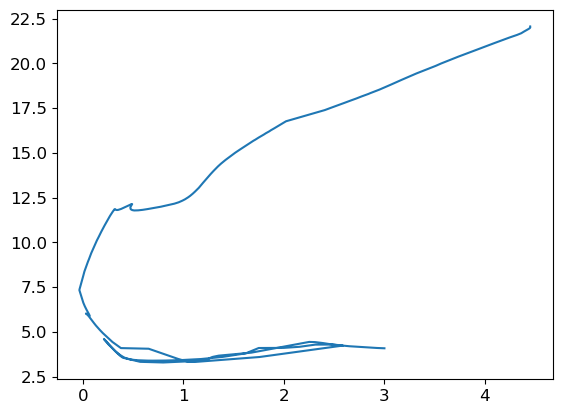

In [62]:
thiso = cl.theoretical_isochrone()
plt.plot(thiso['BP-RP'],thiso['Gmag'])

In [40]:
thiso = get_theoretical_isochrone(3.1,7,0)

getting isochrone form cmd3.7 with Av:3.10, logage:7.00, metallicity:0.00


In [41]:
thiso

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,Teff0,omega,angvel,vtaneq,angmom,Rpol,Req,mbolmag,G_fSBmag,G_BP_fSBmag,G_RP_fSBmag,G_fSB,G_f0,G_fk,G_i00,G_i05,G_i10,G_i15,G_i20,G_i25,G_i30,G_i35,G_i40,G_i45,G_i50,G_i55,G_i60,G_i65,G_i70,G_i75,G_i80,G_i85,G_i90,G_BP_fSB,G_BP_f0,G_BP_fk,G_BP_i00,G_BP_i05,G_BP_i10,G_BP_i15,G_BP_i20,G_BP_i25,G_BP_i30,G_BP_i35,G_BP_i40,G_BP_i45,G_BP_i50,G_BP_i55,G_BP_i60,G_BP_i65,G_BP_i70,G_BP_i75,G_BP_i80,G_BP_i85,G_BP_i90,G_RP_fSB,G_RP_f0,G_RP_fk,G_RP_i00,G_RP_i05,G_RP_i10,G_RP_i15,G_RP_i20,G_RP_i25,G_RP_i30,G_RP_i35,G_RP_i40,G_RP_i45,G_RP_i50,G_RP_i55,G_RP_i60,G_RP_i65,G_RP_i70,G_RP_i75,G_RP_i80,G_RP_i85,G_RP_i90,BP-RP,Gmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.01471,0.0,7.0,0.0900000036,1.0816895926,0.09,-2.064,3.3992,4.005,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.63e-15,0.0,0.7107,0.2745,0.002655,0.0007163,0.006496,-1.0,0.01476,2507.0,0,0,0,0,0.4942,0.4942,9.93,14.573,17.94,12.488,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,14.573,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,12.488,5.452000000000002,14.573
0.01471,0.0,7.0,0.0939977095,1.1189163837,0.094,-2.039,3.4019,4.01,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.74e-15,0.0,0.7107,0.2745,0.002655,0.0007163,0.006496,-1.0,0.01476,2523.0,0,0,0,0,0.5026,0.5026,9.869,14.512,17.88,12.427,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,14.512,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,17.88,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,12.427,5.452999999999999,14.512
0.01471,0.0,7.0,0.1000000015,1.1711064122,0.1,-2.002,3.4058,4.015,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.93e-15,0.0,0.7107,0.2745,0.002655,0.0007163,0.006496,-1.0,0.01476,2545.0,0,0,0,0,0.5151,0.5151,9.774,14.417,17.787,12.332,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,14.417,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,17.787,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,12.332,5.454999999999998,14.417
0.01471,0.0,7.0,0.1048719734,1.2105610995,0.105,-1.973,3.4089,4.02,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-4.07e-15,0.0,0.7107,0.2745,0.002655,0.0007163,0.006496,-1.0,0.01476,2564.0,0,0,0,0,0.526,0.526,9.704,14.347,17.718,12.262,14.347,14.347,14.347,14.347,14.347,14.347,14.347,14.347,14.347,14.347,14.347,14.3

In [35]:
thiso['Gmag'] = thiso['Gmag']+ 5*np.log10(2000)-5
thiso['Gmag']

26.078149978319907
26.017149978319907
25.922149978319908
25.852149978319908
25.713149978319905
25.595149978319906
25.590149978319907
25.389149978319907
25.229149978319906
25.140149978319904
24.88214997831991


In [65]:
cl = Cluster("Alessi_43")
ra = cl.runaways_all()
ra['Temp. Est'] = ra['Teff']
ra.write(f"./Clusters/{cl.name}/{cl.name}_runaways_all.tsv", format='ascii.ecsv', overwrite=True)

In [6]:
from runaway_functionsv2 import theoretical_isochrone
cl = Cluster("Alessi_43")
ra = cl.runaways_all()
ra['Temp. Est'] = ra['Teff']
ra


RA_ICRS_1,DE_ICRS_1,e_RA_ICRS,e_DE_ICRS,_r_1,HIP,TYC2,Source,rgeo,Plx,e_Plx,pmRA,pmDE,e_pmRA,e_pmDE,RUWE,Teff,logg,Gmag,BP-RP,BPmag,RPmag,RV,e_RV,b_rgeo,B_rgeo,FG,e_FG,FBP,e_FBP,FRP,e_FRP,RAVE5,RAVE6,e_Gmag,e_BPmag,e_RPmag,e_BP-RP,SkyCoord,rmRA,rmDE,v_pec,Temp. Est
deg,deg,mas,mas,,,,,pc,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,K,log(cm.s**-2),mag,mag,mag,mag,km / s,km / s,pc,pc,,,,,,,,,,,,,"deg,deg,pc",mas / yr,mas / yr,km / s,K
float64,float64,float64,float64,float64,int32,str11,int64,float64,float64,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,str1,str1,float64,float32,float32,float32,SkyCoord,float64,float64,float64,float64
132.98671546278,-41.67380294722,0.0076,0.0094,16.3689,--,7684-947-1,5524617227420570240,828.71801800,1.1916,0.0106,8.476,3.166,0.010,0.012,0.945,--,--,9.615953,1.578032,10.358509,8.780477,5.27,0.13,821.67810100,834.74066200,2682658.85519,486.4,9.818e+05,495.1,2.438e+06,523.2,--,--,0.002762,0.002843,0.003787,0.00663,"132.98671546278,-41.67380294722,828.718018",14.006720710754395,-0.75391925239563,55.099771647367824,--
132.26918571419,-41.86012579175,0.0194,0.0219,17.6322,--,--,5524602036116091520,814.32153300,1.1904,0.0254,-10.707,7.029,0.026,0.029,1.723,8231.5,4.0056,11.258210,0.356719,11.384149,11.027430,31.10,2.85,796.94012500,831.44531200,591102.51261,175.7,3.817e+05,229,3.077e+05,96.41,--,--,0.002774,0.002865,0.003795,0.00666,"132.26918571419,-41.86012579175,814.321533",-5.176279289245606,3.10908074760437,23.30687698503049,8231.5
133.04493592329,-41.59435475046,0.0241,0.0283,20.7259,--,7684-653-1,5524617914615284992,979.94305400,1.0132,0.0324,-0.307,7.280,0.029,0.034,2.451,--,--,11.336214,1.615958,12.098172,10.482214,26.91,0.22,947.73254400,1010.28107000,550124.88210,174.1,1.978e+05,106.3,5.085e+05,146.3,--,--,0.002777,0.002851,0.003792,0.006643,"133.04493592329,-41.59435475046,979.943054",5.223720710754394,3.3600807476043704,28.849989642023935,--
132.73410499438,-41.84178400134,0.0099,0.0105,6.2903,--,--,5524590426825145856,1018.10675000,0.9673,0.0125,0.455,-1.558,0.014,0.014,1.012,--,--,11.569294,1.596606,12.318983,10.722377,17.29,0.22,1003.93256000,1031.12170000,443842.79468,134.2,1.614e+05,129.4,4.076e+05,174.6,--,--,0.002775,0.002923,0.003808,0.006731,"132.73410499438,-41.84178400134,1018.10675",5.985720710754395,-5.47791925239563,39.156590279772615,--
132.59406399603,-42.09002153710,0.0079,0.0094,19.7340,--,--,5524580526922315776,967.59924300,1.0075,0.0104,-1.221,-0.708,0.011,0.012,0.895,--,--,11.824070,0.888767,12.178180,11.289412,6.41,4.58,955.04718000,978.97412100,351009.54390,43.63,1.837e+05,94.49,2.418e+05,69.53,--,--,0.002759,0.002845,0.003792,0.006638,"132.59406399603,-42.0900215371,967.599243",4.3097207107543944,-4.62791925239563,29.003925519374672,--
133.00847043200,-41.59308957469,0.0081,0.0098,19.3563,--,7684-575-1,5524618155133464576,811.05267300,1.2004,0.0111,-0.255,2.102,0.010,0.012,0.964,--,--,12.213220,0.457366,12.382430,11.925064,11.78,3.30,803.58398400,818.88946500,245278.17556,38.01,1.522e+05,64.06,1.346e+05,37.87,--,--,0.00276,0.002827,0.003792,0.006619,"133.008470432,-41.59308957469,811.052673",5.275720710754395,-1.81791925239563,21.452265989142795,--
132.87533316669,-41.69470930427,0.0068,0.0081,11.2519,--,--,5524616261047795200,852.32055700,1.1546,0.0090,-11.087,2.875,0.009,0.010,0.864,5947.3,3.7638,12.487675,0.887664,12.844776,11.957112,46.70,1.21,845.25250200,859.78521700,190492.02971,28.59,9.943e+04,69.04,1.307e+05,47.97,--,--,0.00276,0.00289,0.0038,0.006691,"132.87533316669,-41.69470930427,852.320557",-5.556279289245605,-1.0449192523956299,22.84086340674451,5947.3
132.61000098041,-41.54121706697,0.0077,0.0088,13.3811,--,--,5524610458552201472,894.27368200,1.0954,0.0101,-15.826,12.544,0.010,0.011,1.000,--,--,12.577625,0.760202,12.872737,12.112535,--,--,885.06213400,901.41918900,175346.30748,23.81,9.69e+04,53.97,1.133e+05,31.75,--,--,0.

In [61]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion,PixCoord, PointSkyRegion, PointPixelRegion, LineSkyRegion, LinePixelRegion
%matplotlib qt
allrun = cl.runaways_all()[:]
allrun_coord_now = SkyCoord(ra=allrun['RA_ICRS_1'], 
                        dec=allrun['DE_ICRS_1'],
                        distance=allrun['rgeo'], 
                        pm_ra_cosdec=allrun['rmRA'],
                        pm_dec=allrun['rmDE'],
                        obstime=Time('J2000')+500*u.kyr)

allrun_coord_earlier = allrun_coord_now.apply_space_motion(dt=-100*u.kyr)


with fits.open('./Clusters/Basel_8/Basel_8_extra10pc.fits') as fits_file:
    image = fits_file[0]
    wcs = WCS(image.header)
    fig, ax = plt.subplots(subplot_kw={'projection': wcs}, figsize=(8, 8))
    ax.imshow(image.data, 
              cmap='gray')
    ax.set_xlabel('Right Ascension (hms)')
    ax.set_ylabel('Declination (degrees)')

    c = SkyCoord("98.5582 +8.0381", distance=1456, unit=(u.deg ,u.deg, u.pc))
    radius = Angle(0.3, 'deg')
    region = CircleSkyRegion(c,radius)
    region_pix = region.to_pixel(wcs)
    region_pix.plot(ax=ax, 
                    color='red', 
                    lw=2)
    
    start_skys = allrun_coord_now
    end_skys = allrun_coord_earlier

    region_sky = [LineSkyRegion(start=start_sky, end=end_sky) for start_sky,end_sky in zip(allrun_coord_now,allrun_coord_earlier)]
    region_sky_pix = [region_sky_.to_pixel(wcs) for region_sky_ in region_sky]
    for c in allrun_coord_now:
        point_sky = PointSkyRegion(center=c)
        point_pix = point_sky.to_pixel(wcs)
        point_pix.plot(ax=ax,
                       color='yellow')
    for region_pix in region_sky_pix:
        region_pix.plot(ax=ax,
                        color='cyan')

/usr/lib/python3/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [37]:
dias2021 = Table.read("dias2021.tsv", format="ascii.ecsv")
maskplx = dias2021['Plx'] > 0.3
maskage = dias2021['logage'] < 7.7
workclusters = []
for clustername in dias2021[maskplx & maskage][:]['Cluster']:
    if clustername not in ['ASCC_79','BH_164','BH_23','Collinder_135','Collinder_140','Gulliver_9','IC_2391','IC_2602','Mamajek_1','Platais_8','UPK_535','UPK_606','UPK_640','Berkeley_59','COIN-Gaia_37','Ivanov_4','LP_1937','Sigma_Ori','UBC_632']:
        workclusters.append(clustername)
        # print(clustername)
        # cl = Cluster(clustername)
        # cl.prepare_trace()
# cl.stars_in_region()
# cl.stars_in_region()

In [ ]:
workclusters_mask = [cluster in workclusters for cluster in dias2021['Cluster']]
workclusterstable = dias2021[workclusters_mask]

rvexists = workclusterstable['RV'].mask
nrvgood = workclusterstable['NRV'] > 4

workclusterstable[~rvexists & nrvgood]

In [ ]:
def runaways_from(clustername):
    cl = Cluster(clustername)
    fs4giesler = cl.fast_stars_in_region()
    outputs = os.listdir(f"/home/surodeep/suro_aiu/traceback/cluster_runaway/{cl.name}/runaways/")
    linenos = []
    for output in outputs:
        #print(output)
        if 'run' in output:
            linenos.append(int(output.split("+")[1].replace(".out","")))
    linenos.sort()
    # print(linenos)
    i=np.array(linenos)-3
    def source_of(lineno, input_table):
        return input_table[lineno-2]['Source']
    return fs4giesler[i]
for cluster in workclusters:
    t = runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Teff']
    
    if t>10000:
        print(cluster, t,runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Source'])